In [1]:
# Here you may import all the required libraries 
import ee
import geemap
import rasterio as rio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import random
import shapely
from shapely.geometry import Point

# Do authenticate the google earth engine code editor here.... 
ee.Authenticate()
ee.Initialize()

# This is an instance of geemap.Map() for visualization, you can also use folium for the html visualization if you are good in that
Map = geemap.Map()

# Area of Interest
aoi = ee.Geometry.Rectangle([76.15998, 9.88114, 76.42001, 10.18006])

In [2]:
# Landsat 9 OLI collection
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2016-01-15', '2016-01-17') \
    .filterBounds(aoi)

# This is available in GEE dataset portal, you can check for the scaling factor as mentioned by NASA
def apply_scale_factors(image):
    # Apply scaling to optical bands (SR_B1 to SR_B7)
    optical_bands = image.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']) \
        .multiply(0.0000275).add(-0.2)
    # Apply scaling to the thermal band (ST_B10)
    thermal_bands = image.select('ST_B10') \
        .multiply(0.00341802).add(149.0)
    # Here we add scaled bands to the image
    return image.addBands(optical_bands, None, True) \
                .addBands(thermal_bands, None, True)

# Now you can apply the scaling function to our image/dataset
dataset = dataset.map(apply_scale_factors)
# Here you can use an aoi (Lat,Long, Min, Max) or an Object for clipping the image to region of interest
LSat0820160116 = dataset.mosaic().clip(aoi)
# Hell, Yeah !! Now you can check the bands available using this print statement
band_names = LSat0820160116.bandNames()
print("Band names:", band_names.getInfo())
# Visualize the dataset with specific bands
visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # RGB bands for true color
    'min': 0.0,
    'max': 0.3,
}


def calculate_indices(image):
    # Calculate NDVI
    NDVI = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    # Calculate NDWI
    NDWI = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    # Calculate NDBI
    NDBI = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    # Add indices to the image
    return image.addBands([NDVI, NDWI, NDBI])


# Apply the function to the individual image
LSat0820160116_with_indices = calculate_indices(LSat0820160116)
# Check the updated bands
band_names = LSat0820160116_with_indices.bandNames()
print("Updated band names:", band_names.getInfo())
# Visualize the dataset with indices
visualization_indices = {
    'bands': ['NDVI', 'NDWI', 'NDBI'],  # Visualizing the indices
    'min': -1.0,
    'max': 1.0,
}

Kochi_Image = LSat0820160116_with_indices.select(['NDBI', 'NDVI', 'NDWI', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']).toFloat()

# Check the updated bands
band_names = Kochi_Image.bandNames()
print("Updated band names:", band_names.getInfo())


# Let us make maps using geemap
Map.center_object(aoi, zoom=10)
Map.addLayer(Kochi_Image, visualization, 'TCC 2024')

# Display the map
Map


Band names: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT']
Updated band names: ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'SR_QA_AEROSOL', 'ST_B10', 'ST_ATRAN', 'ST_CDIST', 'ST_DRAD', 'ST_EMIS', 'ST_EMSD', 'ST_QA', 'ST_TRAD', 'ST_URAD', 'QA_PIXEL', 'QA_RADSAT', 'NDVI', 'NDWI', 'NDBI']
Updated band names: ['NDBI', 'NDVI', 'NDWI', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']


Map(center=[10.030602313293732, 76.28999500000108], controls=(WidgetControl(options=['position', 'transparent_…

In [3]:
# # Export the image to Google Drive as a GeoTIFF
# geemap.ee_export_image_to_drive(
#     image=Kochi_Image,
#     description='LSat092024_Kochi',  
#     folder='EarthEngineExports', 
#     fileNamePrefix='LSat092024_Kochi',
#     scale=30,  
#     region=aoi, 
#     crs='EPSG:4326',  
#     maxPixels=1e13 
# )

In [4]:
# Load the shapefile get the details 
shapefile_path = r"C:\Users\abhij\Desktop\Kochi\Shapefiles\K2016_labels\Kochi2016_label.shp"
gdf = gpd.read_file(shapefile_path)
# Print the column names (attributes)
print("Column names:", gdf.columns)
# Print the first few rows of the attribute table
print(gdf.head())

Column names: Index(['label', 'value', 'geometry'], dtype='object')
        label  value                                           geometry
0       Urban      1  MULTIPOLYGON (((76.17878 10.17201, 76.17898 10...
1       Water      2  MULTIPOLYGON (((76.16228 9.92945, 76.1658 9.93...
2  Vegetation      3  MULTIPOLYGON (((76.40189 9.9737, 76.40314 9.97...
3      Barren      4  MULTIPOLYGON (((76.20497 10.048, 76.20544 10.0...


                    geometry  label
0   POINT (76.35436 9.98284)  Urban
1  POINT (76.39195 10.15437)  Urban
2  POINT (76.39161 10.15386)  Urban
3    POINT (76.2657 9.98658)  Urban
4   POINT (76.24205 9.96539)  Urban


<Axes: >

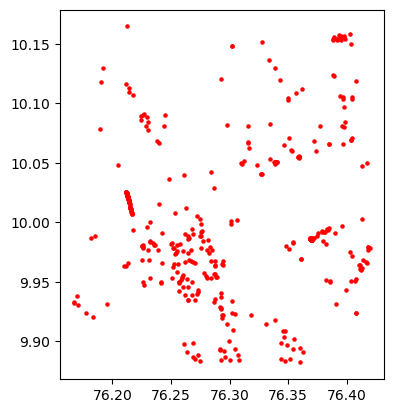

In [5]:
# Load the shapefile
shapefile_path = r"C:\Users\abhij\Desktop\Kochi\Shapefiles\K2016_labels\Kochi2016_label.shp"
gdf = gpd.read_file(shapefile_path)

# Function to generate random points within a polygon
def generate_random_points(polygon, n_points=100):
    minx, miny, maxx, maxy = polygon.bounds  # Get the bounds of the polygon
    points = []
    while len(points) < n_points:
        # Generate a random point within the bounding box of the polygon
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        # Check if the point is within the polygon
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Create an empty GeoDataFrame to store the random points
random_points = []

# Loop through each row in the shapefile and generate random points within each polygon
for _, row in gdf.iterrows():
    polygon = row['geometry']
    label = row['label']
    # Generate 100 random points within the polygon
    points = generate_random_points(polygon, 100)
    # Add points with their respective label to the random points list
    for point in points:
        random_points.append({'geometry': point, 'label': label})

# Create a GeoDataFrame from the random points
random_gdf = gpd.GeoDataFrame(random_points, columns=['geometry', 'label'], crs=gdf.crs)
# Display the first few rows of the random points GeoDataFrame
print(random_gdf.head())
# You can visualize the points if needed (optional)
random_gdf.plot(marker='o', color='red', markersize=5)


                   geometry  label
0  POINT (76.28348 9.98486)  Urban
1  POINT (76.24832 9.98247)  Urban
2  POINT (76.28886 9.96776)  Urban
3   POINT (76.2745 9.96223)  Urban
4  POINT (76.27146 9.94804)  Urban


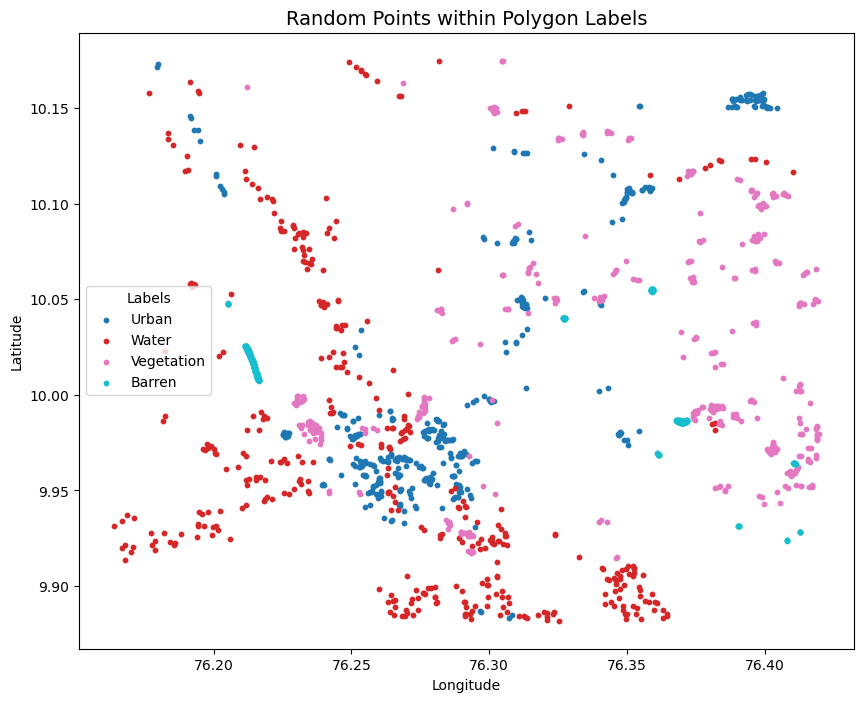

In [6]:
# Load the shapefile
shapefile_path = r"C:\Users\abhij\Desktop\Kochi\Shapefiles\K2016_labels\Kochi2016_label.shp"
gdf = gpd.read_file(shapefile_path)

# Function to generate random points within a polygon
def generate_random_points(polygon, n_points=20):
    minx, miny, maxx, maxy = polygon.bounds  # Get the bounds of the polygon
    points = []
    while len(points) < n_points:
        # Generate a random point within the bounding box of the polygon
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        # Check if the point is within the polygon
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Create an empty list to store the random points and their labels
random_points = []

# Loop through each row in the shapefile and generate random points within each polygon
for _, row in gdf.iterrows():
    polygon = row['geometry']
    label = row['label']
    # Only generate random points if the polygon is valid (not empty)
    if polygon.is_valid and polygon.area > 0:
        # Generate 100 random points within the polygon
        points = generate_random_points(polygon, 400)
        # Add points with their respective label to the random points list
        for point in points:
            random_points.append({'geometry': point, 'label': label})

# Create a GeoDataFrame from the random points
random_gdf = gpd.GeoDataFrame(random_points, columns=['geometry', 'label'], crs=gdf.crs)
# Display the first few rows of the random points GeoDataFrame
print(random_gdf.head())

# Get unique labels for color mapping
unique_labels = random_gdf['label'].unique()
# Define a color map for labels
colors = plt.cm.get_cmap('tab10', len(unique_labels))

# Plot the random points with different colors for each label
fig, ax = plt.subplots(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    # Filter points by label
    label_points = random_gdf[random_gdf['label'] == label]
    # Plot points with the specific color for each label
    ax.scatter(label_points.geometry.x, label_points.geometry.y, label=label, color=colors(i), s=10)

# Add a legend
ax.legend(title='Labels')
# Set title and labels for the plot
ax.set_title('Random Points within Polygon Labels', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


In [8]:
"""THE CODE USED FOR EXTRACTING BAND INFORMATIONS"""
# Load the shapefile
shapefile_path = r"C:\Users\abhij\Desktop\Kochi\Shapefiles\K2016_labels\Kochi2016_label.shp"
gdf = gpd.read_file(shapefile_path)

# Function to generate random points within a polygon
def generate_random_points(polygon, n_points=100):
    minx, miny, maxx, maxy = polygon.bounds  # Get the bounds of the polygon
    points = []
    while len(points) < n_points:
        # Generate a random point within the bounding box of the polygon
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        # Check if the point is within the polygon
        if polygon.contains(random_point):
            points.append(random_point)
    return points

# Create an empty list to store the random points and their labels
random_points = []

# Loop through each row in the shapefile and generate random points within each polygon
for _, row in gdf.iterrows():
    polygon = row['geometry']
    label = row['label']
    # Only generate random points if the polygon is valid (not empty)
    if polygon.is_valid and polygon.area > 0:
        # Generate 100 random points within the polygon
        points = generate_random_points(polygon, 800)
        # Add points with their respective label to the random points list
        for point in points:
            random_points.append({'geometry': point, 'label': label})

# Create a GeoDataFrame from the random points
random_gdf = gpd.GeoDataFrame(random_points, columns=['geometry', 'label'], crs=gdf.crs)
# Get the bands (SR_B1 to SR_B7, ST_B10)
bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7','NDVI', 'NDWI', 'NDBI']
"""--------------------------------------------------------------------------------------------------------"""
# Function to extract band values using reduceRegion
def extract_band_values(point, image, bands):
    point_geojson = ee.Geometry.Point([point.x, point.y])
    # Reduce the region to get band values
    band_values = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point_geojson,
        scale=30,
        maxPixels=1e13  # Handle large computation areas
    ).getInfo()
    return band_values

# Mapping labels to integers for CSV export
label_map = {'Urban': 0, 'Water': 1, 'Vegetation': 2, 'Barren': 3}

# Initialize an empty list for storing the results
extracted_data = []

# Loop through the points and extract band values
for _, row in random_gdf.iterrows():
    point = row['geometry']
    label = row['label']

    try:
        # Extract the band values
        band_values = extract_band_values(point, Kochi_Image, bands)

        # Add the label, latitude, and longitude to the band values
        if band_values:  # Only process if band values are valid
            band_values['label'] = label_map.get(label, -1)  # Default to -1 if label not found
            band_values['latitude'] = point.y
            band_values['longitude'] = point.x
            extracted_data.append(band_values)
    except ee.EEException as e:
        print(f"Error processing point {point}: {e}")

# # Convert the extracted data to a pandas DataFrame
# df = pd.DataFrame(extracted_data)

# # Save the DataFrame to a CSV file
# csv_path = r"C:\Users\abhij\Desktop\Kochi\LandUseLandCover\Kochi2016_lulc\Kochi_Extracted_Values_2016.csv"
# df.to_csv(csv_path, index=False)

# print(f"Band values with labels saved to {csv_path}")


Band values with labels saved to C:\Users\abhij\Desktop\Kochi\LandUseLandCover\Kochi2016_lulc\Kochi_Extracted_Values_2016.csv


In [9]:
df = pd.read_csv(r"C:\Users\abhij\Desktop\Kochi\LandUseLandCover\Kochi2016_lulc\Kochi_Extracted_Values_2016.csv")
Kochi_Train_Test = df.iloc[:,:]
Kochi_Train_Test

,NDBI,NDVI,NDWI,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,label,latitude,longitude
0,0.035636,0.234907,-0.273371,0.073212,0.083855,0.104892,0.113885,0.183818,0.197403,0.152440,0,9.961215,76.267483
1,0.171383,0.134811,-0.158482,0.094305,0.104480,0.110393,0.115865,0.151973,0.214838,0.179033,0,9.978739,76.277879
2,0.233727,0.195809,-0.396731,0.063313,0.083883,0.122878,0.191325,0.284495,0.458048,0.385915,0,10.157160,76.395793
3,0.116499,0.210287,-0.245925,0.087898,0.093920,0.102115,0.110090,0.168720,0.213215,0.177217,0,9.967468,76.284262
4,-0.123620,0.056338,-0.018375,0.051268,0.063368,0.083003,0.076925,0.086110,0.067162,0.053193,0,9.946169,76.287178
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,-0.054724,0.191170,-0.297858,0.161433,0.208870,0.292333,0.366913,0.540355,0.484282,0.249873,3,9.986132,76.369498
3196,0.201775,0.259832,-0.413049,0.068757,0.079373,0.111685,0.157967,0.268875,0.404808,0.291948,3,10.039717,76.327383
3197,0.165843,0.169799,-0.225187,0.121612,0.132530,0.169655,0.190390,0.268270,0.374943,0.347580,3,10.021128,76.212868
3198,-0.059516,0.204675,-0.309971,0.148178,0.188135,0.267033,0.334682,0.506943,0.449990,0.245830,3,9.985342,76.370310


In [10]:
from sklearn.impute import SimpleImputer
x = df.iloc[:,:-3].values
# Option 1: Impute missing values with median
imputer = SimpleImputer(strategy='median')
x = imputer.fit_transform(x)
# Option 2: direct nan to num()
#x = np.nan_to_num(x)
y = df.iloc[:,-3]

#split the dataset into train and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=None)

"""Feature scaling is not required for Random Forest since it is tree based algorithm"""
# #Feature Scaling 
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

'Feature scaling is not required for Random Forest since it is tree based algorithm'

In [11]:
from sklearn.ensemble import RandomForestClassifier
classifier2016 = RandomForestClassifier(n_estimators = 5000,
                                             criterion = 'entropy',
                                               random_state = None,
                                               bootstrap= True)
classifier2016.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5000)

In [12]:
y_pred = classifier2016.predict(x_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[78  0  7  1]
 [ 0 85  0  1]
 [ 0  0 84  0]
 [ 1  0  0 63]]


0.96875

In [13]:
Load_Kochi2016_export = rio.open(r"C:\Users\abhij\Desktop\Kochi\LandUseLandCover\Kochi2016_lulc\LSat092016_Kochi.tif").read()
Load_Kochi2016_export.shape

(10, 1110, 965)

In [14]:
# Assuming `Load_Kochi2024_export` is your 3D NumPy array
bands, rows, cols = Load_Kochi2016_export.shape  
# Reshape the array into (1110 * 965, 10)
reshaped_array = Load_Kochi2016_export.reshape(bands, rows * cols).T 
# Create a DataFrame
column_names = [f'Band_{i+1}' for i in range(bands)]  
df = pd.DataFrame(reshaped_array, columns=column_names)
# Print the shape to confirm
print(f"DataFrame shape: {df.shape}") 

DataFrame shape: (1071150, 10)


In [15]:
Kochi_2016= df.iloc[:,:].values
imputer = SimpleImputer(strategy='median')
Kochi_2016 = imputer.fit_transform(Kochi_2016)
Kochi_2016 = np.nan_to_num(Kochi_2016)

In [16]:
# loaded model to compute predictions
y_pred = classifier2016.predict(Kochi_2016)

In [17]:
y_pred.shape

(1071150,)

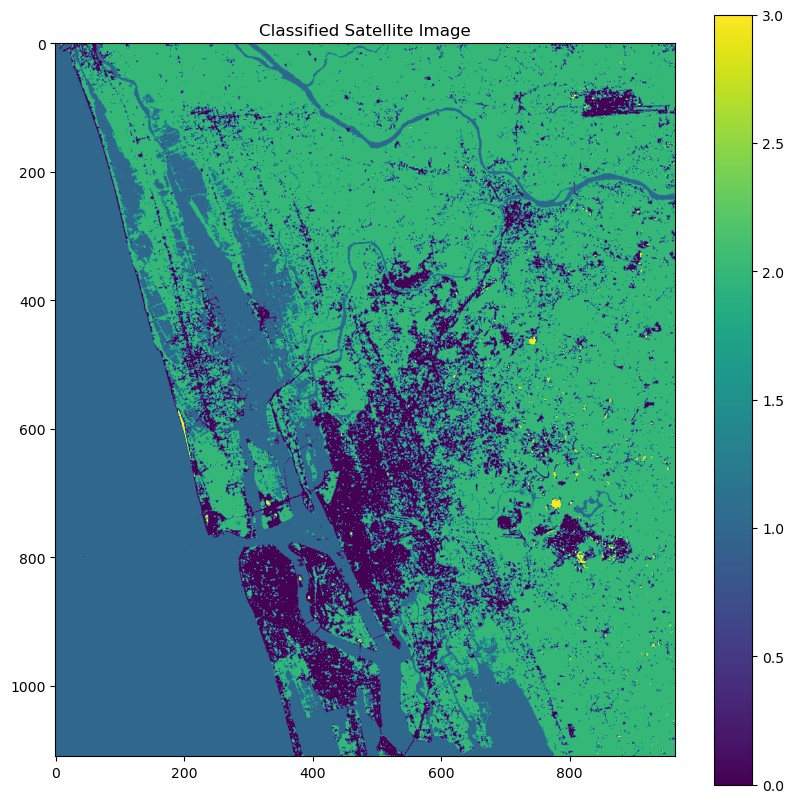

Classified image saved to classified_2016.tif


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin

# Assuming y_pred is your predicted classification result
# Example dimensions
rows = 1110  # Replace with actual number of rows from original image
cols = 965   # Replace with actual number of columns from original image

# Reshape the predicted labels back into the original resolution
y_pred_reshaped = y_pred.reshape((rows, cols))

# Visualize the classified image
plt.figure(figsize=(10, 10))
plt.imshow(y_pred_reshaped, cmap='viridis')  # You can choose another colormap
plt.title("Classified Satellite Image")
plt.colorbar()
plt.show()

# Load the original satellite image to extract spatial metadata
with rasterio.open(r"C:\Users\abhij\Desktop\Kochi\LandUseLandCover\Kochi2016_lulc\LSat092016_Kochi.tif") as src:  # Replace with your file
    original_transform = src.transform  # Spatial transform of the original image
    original_crs = src.crs  # Coordinate reference system of the original image

# # Export the classified image with the correct spatial metadata
# output_path = 'classified_2016.tif'
# with rasterio.open(output_path, 'w', driver='GTiff',
#                    count=1, dtype='uint8', height=rows, width=cols,
#                    crs=original_crs, transform=original_transform) as dst:
#     dst.write(y_pred_reshaped.astype(np.uint8), 1)

# print(f"Classified image saved to {output_path}")


In [ ]:
# from rasterio.transform import from_origin
# from rasterio.plot import show
# from rasterio.warp import transform

# # Load the original satellite image and get its metadata
# with rasterio.open(r"C:\Users\abhij\Desktop\Kochi\LandUseLandCover\Kochi2024_lulc\LSat092024_Kochi.tif") as src:
#     # Retrieve the affine transform and CRS from the image
#     transform = src.transform
#     crs = src.crs
#     rows, cols = src.height, src.width  # Dimensions of the image
#     # Assuming your image has only one band for simplicity (modify for multi-band)
#     img_data = src.read(1)

# # Convert pixel coordinates (i, j) to geographic coordinates (latitude, longitude)
# def pixel_to_geocoordinates(i, j, transform):
#     """Convert pixel indices to geographic coordinates (lat, lon)."""
#     x, y = transform * (j, i)  # (col, row) -> (x, y) in real-world coordinates
#     return x, y

# # Create an array of geographic coordinates corresponding to the image pixels
# geo_coords_x = np.zeros((rows, cols))
# geo_coords_y = np.zeros((rows, cols))
# for i in range(rows):
#     for j in range(cols):
#         geo_coords_x[i, j], geo_coords_y[i, j] = pixel_to_geocoordinates(i, j, transform)

# # Define class colors
# class_colors = {
#     'Urban': [255, 0, 0],       # Red
#     'Water': [0, 0, 255],       # Blue
#     'Vegetation': [0, 255, 0],  # Green
#     'Barren': [255, 255, 0]     # Yellow
# }

# # Map the predicted labels (y_pred) to RGB colors (for visualization)
# rgb_image = np.zeros((rows, cols, 3), dtype=np.uint8)
# for i in range(rows):
#     for j in range(cols):
#         predicted_class = y_pred_reshaped[i, j]  # Assuming y_pred_reshaped is available
#         # Map the predicted class to its corresponding color
#         if predicted_class == 0:
#             rgb_image[i, j] = class_colors['Urban']
#         elif predicted_class == 1:
#             rgb_image[i, j] = class_colors['Water']
#         elif predicted_class == 2:
#             rgb_image[i, j] = class_colors['Vegetation']
#         elif predicted_class == 3:
#             rgb_image[i, j] = class_colors['Barren']

# # Set the font to Times New Roman
# plt.rcParams['font.family'] = 'Times New Roman'
# # Visualize the classified image with real-world coordinates
# plt.figure(figsize=(9, 10))
# plt.imshow(rgb_image)
# # Add coordinate labels to the x and y axes (in geographic coordinates)
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# # Calculate the 1/4th and 3/4th positions for geographic coordinates
# x_1_4 = geo_coords_x.min() + 0.25 * (geo_coords_x.max() - geo_coords_x.min())
# x_3_4 = geo_coords_x.min() + 0.75 * (geo_coords_x.max() - geo_coords_x.min())
# y_1_4 = geo_coords_y.min() + 0.25 * (geo_coords_y.max() - geo_coords_y.min())
# y_3_4 = geo_coords_y.min() + 0.75 * (geo_coords_y.max() - geo_coords_y.min())
# # Update the tick positions and labels without the min and max values
# plt.xticks([int(cols / 4), int(3 * cols / 4)], 
#            labels=[round(x_1_4, 2), round(x_3_4, 2)])
# plt.yticks([int(rows / 4), int(3 * rows / 4)], 
#            labels=[round(y_1_4, 2), round(y_3_4, 2)], rotation =90)

# # Show the color legend
# import matplotlib.patches as mpatches
# legend_elements = [
#     mpatches.Patch(color='r', label='Urban'),
#     mpatches.Patch(color='b', label='Water'),
#     mpatches.Patch(color='green', label='Vegetation'),
#     mpatches.Patch(color='yellow', label='Barren')
# ]
# plt.legend(handles=legend_elements, loc='lower left')

# plt.title("Classified Satellite Image with Geographic Coordinates")
# plt.grid(False)
# # Make the layout tight to remove unwanted white space
# plt.tight_layout()
# plt.show()

In [ ]:
"""EXPORT AS A SHAPEFILE: it is computationally expensive"""
# import numpy as np
# import geopandas as gpd
# from shapely.geometry import Polygon
# from skimage.measure import label, regionprops
# import rasterio
# from rasterio.features import shapes

# # Reshape y_pred into the original image dimensions (rows, cols)
# classified_image = y_pred.reshape((rows, cols))  # Assume rows and cols are defined

# # Assign labels for the four classes
# class_labels = {0: 'Urban', 1: 'Water', 2: 'Vegetation', 3: 'Barren'}


# # Label connected components (regions) for each class
# labeled_image = label(classified_image, connectivity=2)  # 8-connectivity (diagonal neighbors too)

# # Initialize a list to store the polygons
# polygons = []

# # Loop through each region and convert to polygon
# for region in regionprops(labeled_image):
#     minr, minc, maxr, maxc = region.bbox  # Bounding box for the region
#     if region.area > 100:  # Optional: filter small regions
#         # Get the pixel coordinates of the region
#         region_pixels = region.coords
#         # Create the polygon from these coordinates
#         polygon = Polygon([tuple(pixel) for pixel in region_pixels])
#         # Append the polygon with class label information
#         polygons.append({
#             'geometry': polygon,
#             'properties': {'class': class_labels[classified_image[minr, minc]]}
#         })

# # Create GeoDataFrame from the polygons and add labels
# gdf = gpd.GeoDataFrame(polygons)
# # Set the CRS (Coordinate Reference System), assuming WGS84 (you can change it based on your data)
# gdf.set_crs('EPSG:4326', inplace=True)
# # Export to a shapefile
# gdf.to_file("classified_image.shp")



In [ ]:
# Landsat 8 OLI collection
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2015-11-28', '2015-11-30') \
    .filterBounds(aoi)

# This is available in GEE dataset portal, you can check for the scaling factor as mentioned by NASA
def apply_scale_factors(image):
    # Apply scaling to optical bands (SR_B1 to SR_B7)
    optical_bands = image.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']) \
        .multiply(0.0000275).add(-0.2)
    
    # Apply scaling to the thermal band (ST_B10)
    thermal_bands = image.select('ST_B10') \
        .multiply(0.00341802).add(149.0)

    # Here we add scaled bands to the image
    return image.addBands(optical_bands, None, True) \
                .addBands(thermal_bands, None, True)

# Now you can apply the scaling function to our image/dataset
dataset = dataset.map(apply_scale_factors)

# Here you can use an aoi (Lat,Long, Min, Max) or an Object for clipping the image to region of interest
LSat0820160116 = dataset.mosaic().clip(aoi)

# Hell, Yeah !! Now you can check the bands available using this print statement
band_names = LSat0820160116.bandNames()
print("Band names:", band_names.getInfo())

# Visualize the dataset with specific bands
visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],  # RGB bands for true color
    'min': 0.0,
    'max': 0.3,
}

# Let us make maps using geemap
Map.center_object(aoi, zoom=10)
Map.addLayer(LSat0820160116, visualization, 'TCC 2016')

# Display the map
Map

In [ ]:
# Landsat 05 OLI collection
dataset = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filterDate('1992-12-30', '1993-01-01') \
    .filterBounds(aoi)

# This is available in GEE dataset portal, you can check for the scaling factor as mentioned by NASA
def apply_scale_factors(image):
    # Apply scaling to optical bands (SR_B1 to SR_B7)
    optical_bands = image.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']) \
        .multiply(0.0000275).add(-0.2)
    
    # Apply scaling to the thermal band (ST_B10)
    thermal_bands = image.select('ST_B6') \
        .multiply(0.00341802).add(149.0)

    # Here we add scaled bands to the image
    return image.addBands(optical_bands, None, True) \
                .addBands(thermal_bands, None, True)

# Now you can apply the scaling function to our image/dataset
dataset = dataset.map(apply_scale_factors)

# Here you can use an aoi (Lat,Long, Min, Max) or an Object for clipping the image to region of interest
LSat0519921231 = dataset.mosaic().clip(aoi)

# Hell, Yeah !! Now you can check the bands available using this print statement
band_names = LSat0519921231.bandNames()
print("Band names:", band_names.getInfo())

# Visualize the dataset with specific bands
visualization = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],  # RGB bands for true color
    'min': 0.0,
    'max': 0.3,
}

# Let us make maps using geemap
Map.center_object(aoi, zoom=10)
Map.addLayer(LSat0519921231, visualization, 'TCC 1992')

# Display the map
Map